<center><h1>DSCI-552 HOMEWORK 5</h1><center>
<br>
<center><font size="4"></font></center>
<center><font size="3"><strong>Mason(Mohan) Xing</font></center>
<center><font size="3"><strong>USCID:	6880083372</font></center>

In [1]:
# import dependencies
import warnings
warnings.filterwarnings("ignore")

import os
import urllib
import zipfile
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.utils.fixes import loguniform
from sklearn.metrics import accuracy_score, hamming_loss, multilabel_confusion_matrix, silhouette_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.multioutput import ClassifierChain
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# check the environment
print (os.environ['CONDA_DEFAULT_ENV'])

dsci552


# 1. Multi-class and Multi-Label Classification Using Support Vector Machines

## 1(a) Download the Anuran Calls (MFCCs) Data Set 
from: https://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29. Choose 70% of the data randomly as the training set.

Note: The dataset has already been downloaded do not need to run the code below

In [2]:
# download original dataset
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran%20Calls%20(MFCCs).zip"
# datafile = "../data/Anuran Calls (MFCCs).zip"
# urllib.request.urlretrieve(url, datafile)

# with zipfile.ZipFile(datafile, 'r') as zip_ref:
#     zip_ref.extractall("../data/Anuran Calls (MFCCs)")
#     zip_ref.close()

# os.remove(datafile)

In [3]:
# Convert data into dataframe
data_original =  pd.read_csv("../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv")
data_original.info()
data_original.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MFCCs_ 1  7195 non-null   float64
 1   MFCCs_ 2  7195 non-null   float64
 2   MFCCs_ 3  7195 non-null   float64
 3   MFCCs_ 4  7195 non-null   float64
 4   MFCCs_ 5  7195 non-null   float64
 5   MFCCs_ 6  7195 non-null   float64
 6   MFCCs_ 7  7195 non-null   float64
 7   MFCCs_ 8  7195 non-null   float64
 8   MFCCs_ 9  7195 non-null   float64
 9   MFCCs_10  7195 non-null   float64
 10  MFCCs_11  7195 non-null   float64
 11  MFCCs_12  7195 non-null   float64
 12  MFCCs_13  7195 non-null   float64
 13  MFCCs_14  7195 non-null   float64
 14  MFCCs_15  7195 non-null   float64
 15  MFCCs_16  7195 non-null   float64
 16  MFCCs_17  7195 non-null   float64
 17  MFCCs_18  7195 non-null   float64
 18  MFCCs_19  7195 non-null   float64
 19  MFCCs_20  7195 non-null   float64
 20  MFCCs_21  7195 non-null   floa

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


* Choose 70% of the data randomly as the training set.

In [4]:
# check the train/test dataframe spec
train, test = train_test_split(data_original, test_size=0.3, random_state = 42)
print("Training Set Size: ", train.shape)
print("Test Set Size: ", test.shape)

Training Set Size:  (5036, 26)
Test Set Size:  (2159, 26)


In [5]:
# Check if target class missing in training set
print(f"Original data 'Family' class:\n{data_original.Family.value_counts()}")
print("*"*30)
print(f"Train data 'Family' class:\n{train.Family.value_counts()}")

Original data 'Family' class:
Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: Family, dtype: int64
******************************
Train data 'Family' class:
Leptodactylidae    3073
Hylidae            1542
Dendrobatidae       380
Bufonidae            41
Name: Family, dtype: int64


In [6]:
# Check if target class missing in training set
print(f"Original data 'Genus' class:\n{data_original.Genus.value_counts()}")
print("*"*30)
print(f"Train data 'Genus' class:\n{train.Genus.value_counts()}")

Original data 'Genus' class:
Adenomera        4150
Hypsiboas        1593
Ameerega          542
Dendropsophus     310
Leptodactylus     270
Scinax            148
Osteocephalus     114
Rhinella           68
Name: Genus, dtype: int64
******************************
Train data 'Genus' class:
Adenomera        2899
Hypsiboas        1125
Ameerega          380
Dendropsophus     226
Leptodactylus     174
Scinax            111
Osteocephalus      80
Rhinella           41
Name: Genus, dtype: int64


In [7]:
# Check if target class missing in training set
print(f"Original data 'Species' class:\n{data_original.Species.value_counts()}")
print("*"*30)
print(f"Train data 'Species' class:\n{train.Species.value_counts()}")

Original data 'Species' class:
AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
Name: Species, dtype: int64
******************************
Train data 'Species' class:
AdenomeraHylaedactylus    2447
HypsiboasCordobae          788
AdenomeraAndre             452
Ameeregatrivittata         380
HypsiboasCinerascens       337
HylaMinuta                 226
LeptodactylusFuscus        174
ScinaxRuber                111
OsteocephalusOophagus       80
Rhinellagranulosa           41
Name: Species, dtype: int64


The above results the training data does not miss any class within each label.

## 1(b) Each instance has three labels: 
Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multi-label classification is to train a classifier for each label (binary relevance). We first try this approach:

### 1(b) i. Research exact match and hamming score/ loss methods for evaluating multi-label classification and use them in evaluating the classifiers in this problem.
ref: https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd<br>
ref: https://www.linkedin.com/pulse/hamming-score-multi-label-classification-chandra-sharat/ <br>
ref: https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics<br>
ref: A Literature Survey on Algorithms for Multi-label Learning, by Mohammad Sorower

<strong>Exact Match</strong><br>
* The Exact Match Ratio evaluation metric extends the concept the accuracy from the single-label classification problem to a multi-label classification problem.
* One of the drawbacks of using EMR is that is does not account for partially correct labels.

<strong>Hamming loss Methods</strong><br>
* Hamming Loss reports how many times on average, the relevance of an example to a class label is incorrectly predicted. Therefore, hamming loss takes into account the prediction error (an incorrect label is predicted) and the missing error (a relevant label not predicted), normalized over total number of classes and total number of examples.

<strong>Hamming Score Methods</strong><br>
* Calculation is based on correctly predicted label intersection over labels union
* If the number of the prediction labels is the same as true labels it can be 1-loss

In [8]:
# define function to calculate exact match ratio
def emr(y_true, y_pred): # y_true, y_pred has to be dataframe
    '''
    y_true, y_pred have to be dataframes 
    
    '''
    result = {}
    match = 0
    for true, pred in zip(y_true.values, y_pred.values):
        if np.array_equal(true, pred) == True: #test if it is exact match array
            match+=1
    
    result['match_ratio'] = match / y_true.shape[0]
    result['miss_ratio'] =  (y_true.shape[0]-match) / y_true.shape[0]
    
    return result

In [9]:
# define function to calculate hamming loss and hamming score
def hamming(y_true, y_pred): 
    '''
    y_true, y_pred have to be dataframes
    
    '''
    result = {}
    miss_match = 0
    temp_a = None
    temp = 0
    for true, pred in zip(y_true.values, y_pred.values): 
        r = (true == pred) # predicted label in boolean
#         t = [True, True, True] # true label in boolean
#         temp_a = sum(np.logical_and(t, r)) / sum(np.logical_or(t, r))
#         temp += temp_a
        # total partial miss match
        miss_match += true.shape[0]-np.sum(r)
        
    loss = miss_match / ( y_true.shape[0]*y_true.shape[1] )
    score = 1-loss # based on Piazza TA`s explanation
    distance =  miss_match / y_true.shape[0]
    
    result['hamming_score'] = score
    result['hamming_loss'] = loss
    result['hamming_distance'] = distance
    
    return result

### 1(b) ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation.1 You are welcome to try to solve the problem with both standardized and raw attributes and report the results.
ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

In [10]:
# define X, y split function
def xy_split(df):
    
    X = df.iloc[:,:-4] 
    y = df.iloc[: , -4:-1]
    return X, y

In [11]:
# define function to prepare training and testing data
def data_prepare(tr, ts, std=False):      
        
    X_tr, y_tr = xy_split(tr)
    X_ts, y_ts = xy_split(ts)
    
    if std == True:
        scaler = StandardScaler()
        scaler.fit(X_tr)
        X_tr_std = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns, index=y_tr.index)
        X_ts_std = pd.DataFrame(scaler.transform(X_ts), columns=X_ts.columns, index=y_ts.index)
        
        return X_tr_std, X_ts_std, y_tr, y_ts 
    
    else:

        return X_tr, X_ts, y_tr, y_ts

In [12]:
# define a function to print out classifer results:
def evaluation(y_true, y_pred):
    
    y_test_em = emr(y_test, y_pred)['match_ratio']
    y_test_h_score = hamming(y_test, y_pred)['hamming_score']
    y_test_h_loss = hamming(y_test, y_pred)['hamming_loss']
    
    result_df = pd.DataFrame({"Exact Match Ratio": [y_test_em],
                              "Hamming Score": [y_test_h_score],
                              "Hamming Loss": [y_test_h_loss]})
    
    return result_df

In [13]:
X_train, X_test, y_train, y_test = data_prepare(train, test)

# Encoding the variable
label_object = {}
for col in y_train:
    le = LabelEncoder()
    le.fit(y_train[col])
    y_train[col] = le.transform(y_train[col])
    y_test[col] = le.transform(y_test[col])
    label_object[col] = le
    
# label_object['col'].inverse_transform(y_train['col']) # inverse encode label

#### - Raw Attributes

In [14]:
# define SVM model tuning hyperparameters
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
parameters = {'C':np.logspace(-3,6,10), 
              'gamma': np.linspace(2.1,6,40) #usually linear
             }
svc = SVC(kernel = 'rbf', decision_function_shape='ovr')
clf = GridSearchCV(estimator = svc,
                   param_grid = parameters, 
                   scoring='accuracy', 
                   cv=skf, 
                   n_jobs=-1)

In [15]:
# Training Model and Predict labels
temp_dict = {}
y_test_pred_dict = {}
Cs = []
gammas = []
scores = []
for c in tqdm(y_train.columns):
    clf.fit(X_train, y_train[c])
    y_test_pred_dict[c] = clf.predict(X_test)
    
    Cs.append(clf.best_estimator_.C)
    gammas.append(clf.best_estimator_.gamma)
    scores.append(clf.best_score_)
# prediction result df
y_test_pred_bii = pd.DataFrame.from_dict(y_test_pred_dict)
# best hyperparameters df
temp_dict["C"] = Cs
temp_dict["gamma"] = gammas
temp_dict["mean_cv_accuracy"] = scores
best_param_bii = pd.DataFrame.from_dict(temp_dict)
best_param_bii.index = y_train.columns

100%|██████████| 3/3 [06:32<00:00, 130.96s/it]


* Best Cross Validation Hyperparameters For Each Class

In [16]:
# display best classifier hyperparameters
best_param_bii

,C,gamma,mean_cv_accuracy
Family,100.0,2.6,0.993048
Genus,10.0,2.6,0.991064
Species,10.0,2.2,0.990867


* Model Evaluation on Test Data

In [17]:
# display evaluation results
df_bii = evaluation(y_test, y_test_pred_bii)
df_bii.index = ['SVM']
df_bii

,Exact Match Ratio,Hamming Score,Hamming Loss
SVM,0.987957,0.991817,0.008183


#### - Standardized Attributes

In [18]:
# define SVM model tuning hyperparameters
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
steps = []
steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel = 'rbf', decision_function_shape='ovr'))]
pipeline = Pipeline(steps)
parameters_std = {'SVM__C':np.logspace(-1, 1, 3), 
                  'SVM__gamma': np.linspace(0.1, 2, 20) #I reduce the hyperparameter numbers to increase the speed
                 }
clf_std = GridSearchCV(pipeline,
                       param_grid = parameters_std, 
                       scoring='accuracy', 
                       cv=skf, 
                       n_jobs=-1)

In [19]:
# Training Model and Predic labels for standardized features
temp_dict2 = {}
y_test_pred_std_dict = {}
Cs_std = []
gammas_std = []
scores_std = []
for c in tqdm(y_train.columns):
    
    clf_std.fit(X_train, y_train[c])
    y_test_pred_std_dict[c] = clf_std.predict(X_test)
    
    Cs_std.append(clf_std.best_params_['SVM__C'])
    gammas_std.append(clf_std.best_params_['SVM__gamma'])
    scores_std.append(clf_std.best_score_)
# prediction result df    
y_test_pred_bii_std = pd.DataFrame.from_dict(y_test_pred_std_dict)
# best hyperparameters df
temp_dict2["C"] = Cs_std
temp_dict2["gamma"] = gammas_std
temp_dict2["mean_cv_accuracy"] = scores_std
best_param_bii_std = pd.DataFrame.from_dict(temp_dict2)
best_param_bii_std.index = y_train.columns

100%|██████████| 3/3 [04:22<00:00, 87.35s/it]


* Best Cross Validation Hyperparameters For Each Class

In [20]:
# display best classifier hyperparameters
best_param_bii_std

,C,gamma,mean_cv_accuracy
Family,10.0,0.1,0.989277
Genus,10.0,0.1,0.986894
Species,10.0,0.1,0.984710


* Model Evaluation on Test Data

In [21]:
# display evaluation results
df_bii_std = evaluation(y_test, y_test_pred_bii_std)
df_bii_std.index = ['SVM std']
df_bii_std

,Exact Match Ratio,Hamming Score,Hamming Loss
SVM std,0.983789,0.988266,0.011734


### 1(b) iii. Repeat 1(b)ii with L1-penalized SVMs. Remember to standardize the attributes. Determine the weight of the SVM penalty using 10 fold cross validation.

In [22]:
# define SVM model tuning hyperparameters
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
steps = []
steps = [('scaler', StandardScaler()), ('LinearSVC', LinearSVC(penalty = 'l1', multi_class='ovr', dual=False))]
pipeline = Pipeline(steps)
parameters = {'LinearSVC__C':np.logspace(-3,6,10)}
clf_biii = GridSearchCV(pipeline,
                        param_grid = parameters, 
                        scoring='accuracy', 
                        cv=skf, 
                        n_jobs=-1)

In [23]:
# Training Model and Predic labels
temp_dict3 = {}
y_test_pred_biii_dict = {}
Cs = []
scores = []
for c in tqdm(y_train.columns):
    
    clf_biii.fit(X_train, y_train[c])
    y_test_pred_biii_dict[c] = clf_biii.predict(X_test)
    
    Cs.append(clf_biii.best_params_['LinearSVC__C'])
    scores.append(clf_biii.best_score_)
# prediction result df   
y_test_pred_biii = pd.DataFrame.from_dict(y_test_pred_biii_dict)
# best hyperparameters df
temp_dict3["C"] = Cs
temp_dict3["mean_cv_accuracy"] = scores
best_param_biii = pd.DataFrame.from_dict(temp_dict3)
best_param_biii.index = y_train.columns

100%|██████████| 3/3 [00:39<00:00, 13.33s/it]


* Best Cross Validation Hyperparameters For Each Class

In [24]:
# display best classifier hyperparameters
best_param_biii

,C,mean_cv_accuracy
Family,10.0,0.941223
Genus,1000.0,0.951750
Species,10.0,0.960682


* Model Evaluation on Test Data

In [25]:
# display evaluation results
df_biii = evaluation(y_test, y_test_pred_biii)
df_biii.index = ['LinearSVM std']
df_biii

,Exact Match Ratio,Hamming Score,Hamming Loss
LinearSVM std,0.912459,0.943029,0.056971


### 1(b) iv. Repeat 1(b)iii by using SMOTE or any other method you know to remedy class imbalance. Report your conclusions about the classifiers you trained.
ref https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7

In [26]:
# construct pipline for tunning hyperparameters
pipeline = None
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', LinearSVC(penalty = 'l1', multi_class='ovr', dual=False)]])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
parameters = {'classifier__C':np.logspace(-3,6,10)}
clf_biv = GridSearchCV(estimator = pipeline,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = skf,
                           n_jobs = -1)

In [27]:
# Training Model and Predic labels
temp_dict = {}
y_test_pred_biv_dict = {}
Cs = []
scores = []
for c in tqdm(y_train.columns):
    
    clf_biv.fit(X_train, y_train[c])
    y_test_pred_biv_dict[c] = clf_biv.predict(X_test)
    
    Cs.append(clf_biv.best_params_['classifier__C'])
    scores.append(clf_biv.best_score_)
# prediction result df     
y_test_pred_biv = pd.DataFrame.from_dict(y_test_pred_biv_dict)
# best hyperparameters df
temp_dict["C"] = Cs
temp_dict["mean_cv_accuracy"] = scores
best_param_biv = pd.DataFrame.from_dict(temp_dict)
best_param_biv.index = y_train.columns

100%|██████████| 3/3 [04:58<00:00, 99.59s/it] 


* Best Cross Validation Hyperparameters For Each Class

In [28]:
best_param_biv

,C,mean_cv_accuracy
Family,10.0,0.922559
Genus,1.0,0.914227
Species,100.0,0.957906


* Model Evaluation on Test Data

In [29]:
# display evaluation results
df_biv = evaluation(y_test, y_test_pred_biv)
df_biv.index = ['SMOTE LinearSVM std']
df_biv

,Exact Match Ratio,Hamming Score,Hamming Loss
SMOTE LinearSVM std,0.855952,0.924348,0.075652


* Conclusion

In [30]:
dfs = [df_bii, df_bii_std, df_biii, df_biv]
df_report = pd.concat(dfs)
df_report

,Exact Match Ratio,Hamming Score,Hamming Loss
SVM,0.987957,0.991817,0.008183
SVM std,0.983789,0.988266,0.011734
LinearSVM std,0.912459,0.943029,0.056971
SMOTE LinearSVM std,0.855952,0.924348,0.075652


* Normalized data by using SVM(Gaussian Kernel) with original normalized data has the highest Exact Match Ratio and Hamming Score
* The Standardized data using SVM(Gaussian Kernel) also has a very high exact match ratio and hamming score.
* The Standardized data using LinearSVM classifier's perfromance is slightly worse than SVM(Gaussian Kernel)
* SMOTE data using LinearSVM has the lowest Exact Match Ratio and Hamming Score, I think this is reasonable, since we create a lot of new training data for this classifier, may create more noise and the bias during training try hard to fit the new training dataset may cause the variance increasing for data prediction.

### 1(b) v. Extra Practice: Study the Classifier Chain method and apply it to the above problem.

In [31]:
def chain_svm(base_svm, X_tr, X_ts, y_tr, y_ts, c_array):
    
    y_pred_dict ={}
    y_test_em_list =[]
    y_test_h_score_list = []
    y_test_h_loss_list = []
    temp_dict = {}
    
    for i in tqdm(range(len(orders))):
        chain = ClassifierChain(base_svm, order=c_array[i], cv=10)
        y_pred = chain.fit(X_tr, y_tr).predict(X_ts)
        y_pred = pd.DataFrame(y_pred, columns=y_tr.columns) 

        y_test_em_list.append(emr(y_ts, y_pred)['match_ratio'])
        y_test_h_score_list.append(hamming(y_ts, y_pred)['hamming_score'])
        y_test_h_loss_list.append(hamming(y_ts, y_pred)['hamming_loss'])

    temp_dict['exact_match'] = y_test_em_list
    temp_dict['hamming_score'] = y_test_h_score_list
    temp_dict['hamming_loss'] = y_test_h_loss_list
    df_temp = pd.DataFrame.from_dict(temp_dict)
        
    return df_temp

#### - repeat 1(b)ii  Raw Attributes

In [32]:
orders = [[0,1,2], [0,2,1], [1,0,2], [1,2,0], [2,0,1], [2,1,0]]
base_svm = SVC(kernel = 'rbf', decision_function_shape='ovr')
df_bv_ii = chain_svm(base_svm, X_train, X_test, y_train, y_test, orders)

100%|██████████| 6/6 [00:16<00:00,  2.80s/it]


In [33]:
best_result_bv_ii = df_bv_ii.iloc[df_bv_ii['exact_match'].idxmax()]
best_index = df_bv_ii.index.get_loc(best_result_bv_ii.name)
print(f"Best order is:\n{orders[best_index]}\n")
print(f"Best result is:\n{best_result_bv_ii}")

Best order is:
[2, 1, 0]

Best result is:
exact_match      0.978231
hamming_score    0.979775
hamming_loss     0.020225
Name: 5, dtype: float64


#### - repeat 1(b)ii  Standardized Attributes

In [34]:
X_train_std, X_test_std, y_train, y_test = data_prepare(train, test, std=True)
# Encoding the variable
label_object = {}
for col in y_train:
    le = LabelEncoder()
    le.fit(y_train[col])
    y_train[col] = le.fit_transform(y_train[col])
    y_test[col] = le.transform(y_test[col])
    label_object[col] = le

In [35]:
base_svm = SVC(kernel = 'rbf', decision_function_shape='ovr')
df_bv_ii_std = chain_svm(base_svm, X_train_std, X_test_std, y_train, y_test, orders)

100%|██████████| 6/6 [00:19<00:00,  3.26s/it]


In [36]:
best_result_bv_ii_std = df_bv_ii_std.iloc[df_bv_ii_std['exact_match'].idxmax()]
best_index = df_bv_ii_std.index.get_loc(best_result_bv_ii_std.name)
print(f"Best order is:\n{orders[best_index]}\n")
print(f"Best result is:\n{best_result_bv_ii_std}")

Best order is:
[2, 0, 1]

Best result is:
exact_match      0.983789
hamming_score    0.986413
hamming_loss     0.013587
Name: 4, dtype: float64


#### - repeat 1(b)iii  

In [37]:
base_svm = LinearSVC(penalty = 'l1', dual=False)
df_bv_iii= chain_svm(base_svm, X_train_std, X_test_std, y_train, y_test, orders)

100%|██████████| 6/6 [02:37<00:00, 26.28s/it]


In [38]:
best_result_bv_iii = df_bv_iii.iloc[df_bv_iii['exact_match'].idxmax()]
best_index = df_bv_iii.index.get_loc(best_result_bv_iii.name)
print(f"Best order is:\n{orders[best_index]}\n")
print(f"Best result is:\n{best_result_bv_iii}")

Best order is:
[2, 1, 0]

Best result is:
exact_match      0.932376
hamming_score    0.955226
hamming_loss     0.044774
Name: 5, dtype: float64


#### - repeat 1(b)iv

### 1(b)vi. Extra Practice: Research how confusion matrices, precision, recall, ROC, and AUC are defined for multi-label classification and compute them for the classifiers you trained in above.

# 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set
<strong>Monte-Carlo Simulation:</strong> Perform the following procedures 50 times, and report
the average and standard deviation of the 50 Hamming Distances that you calculate.

In [39]:
# split data into X, y
X, y_original = xy_split(data_original)
y = y_original.copy()

In [40]:
# Encoding the variable
label_object = {}
for col in y:
    le = LabelEncoder()
    le.fit(y[col])
    y[col] = le.fit_transform(y[col])
    label_object[col] = le

## 2(a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set 
(do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose k $\in$ {1,2,...50} automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or anyother method you know. <br>
ref: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [41]:
# Define a function to get the optimal K in each MC simulation
def get_best_k(X, i):
    
    silhouette_scores = []
    cl_list = []
    result = {}
    for k in range(1,51):
    
        kmeans = KMeans(n_clusters=k, random_state=i)
        cluster_labels = kmeans.fit_predict(X)
        cl_list.append(cluster_labels)
        
        if k == 1:
            silhouette_avg = 0 # since silhouette_score cant have k=1
            silhouette_scores.append(silhouette_avg)
        else:
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouette_scores.append(silhouette_avg)
            
    index = silhouette_scores.index(max(silhouette_scores))
    result['best_k'] = index + 1
    result['best_cl'] = cl_list[index]
    
    return result

* Sample output

In [42]:
m = 0 # random state/MC run
sample_result = get_best_k(X, m)
print("Selected Best K is:", sample_result['best_k'])

Selected Best K is: 4


## 2(b) In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species.

In [43]:
# Define a function to find the majority true label in each target
def get_majority(y_ori, cl,  i):
    '''
    y_ori is the original label
    cl is cluster labels
    i is index: MC run number
    '''
    y_df = y_ori.copy()
    y_df['cluster_label'] = cl
    # get the majority true labels for each target column by cluster 
    df_Family=y_df.groupby('cluster_label')['Family'].agg(pd.Series.mode).to_frame()
    df_Genus=y_df.groupby('cluster_label')['Genus'].agg(pd.Series.mode).to_frame()
    df_Species=y_df.groupby('cluster_label')['Species'].agg(pd.Series.mode).to_frame()
    result_df = pd.concat([df_Family, df_Genus, df_Species], axis=1, ignore_index=True)
    result_df.columns = y_ori.columns
    # save results in a data frame for (family, genus, species)
    index_arrays = [[i,i,i,i], result_df.index]
    index_tuples = list(zip(*index_arrays))
    index = pd.MultiIndex.from_tuples(index_tuples, names=["Run", "cluster label"])
    result_df.index = index
    
    return result_df

* Sample output

In [44]:
# generate cluster labels
df_m = get_majority(y_original, sample_result['best_cl'], m)
df_m

Family      Genus                 Species
Run cluster label                                                    
0   0              Leptodactylidae  Adenomera  AdenomeraHylaedactylus
    1                Dendrobatidae   Ameerega      Ameeregatrivittata
    2                      Hylidae  Hypsiboas    HypsiboasCinerascens
    3                      Hylidae  Hypsiboas       HypsiboasCordobae

## 2(c) Now for each cluster you have a majority label triplet (family, genus, species). Calculate the average Hamming distance, Hamming score, and Hamming loss between the true labels and the labels assigned by clusters.

* The function below calculate the hamming metric for each cluster (may not apply in this hw)

In [45]:
# define a function to evaluate the hamming metrics for each cluster at each MC simulation
# def cluster_evaluation(y_tr_cl, y_pred_cl, cluster_labels, i):
#     h_cl ={}
#     h_dis_cl =[]
#     h_score_cl = []
#     h_loss_cl = []
#     for j in list(set(cluster_labels)):
        
#         y_tr_temp = y_tr_cl.loc[y_tr_cl.cluster_label==j]
#         y_pred_temp = y_pred_cl.loc[y_pred_cl.cluster_label==j]
#         # evaluate each cluster by hamming metrics
#         h_cl_result = hamming(y_tr_temp[y_original.columns], y_pred_temp[y_original.columns])
#         h_dis_cl.append(h_cl_result['hamming_distance'])
#         h_score_cl.append(h_cl_result['hamming_score'])
#         h_loss_cl.append(h_cl_result['hamming_loss'])
        
#     h_cl['Ave Hamming Distance'] = h_dis_cl
#     h_cl['Ave Hamming Score'] = h_score_cl
#     h_cl['Ave Hamming Loss'] = h_loss_cl
#     df_h_cl = pd.DataFrame.from_dict(h_cl)
#     index_arrays = [[i,i,i,i], df_h_cl.index]
#     index_tuples = list(zip(*index_arrays))
#     index = pd.MultiIndex.from_tuples(index_tuples, names=["Round", "cluster label"])
#     df_h_cl.index = index 
    
#     return df_h_cl

In [46]:
# define a function to assign major triplet to cluster label
def assign_triple(df_majority, cl, i):
    '''
    df_majority is the result dataframe from part 2b
    cl : cluster labels
    i : run number
    '''
    y_pred_dict = {}
    for c in df_majority:
        y_pred_dict[c] = [df_majority[c].loc[i][x] for x in cl]
    y_pred = pd.DataFrame.from_dict(y_pred_dict)
    
    return y_pred

* Sample output

In [47]:
sample_prediction = assign_triple(df_m, sample_result['best_cl'], m)
h_r = hamming(y_original, sample_prediction)
print(f"Run {m}: Average Hamming Distance:{h_r['hamming_distance']}, Hamming Score:{h_r['hamming_score']}, Hamming Loss: {h_r['hamming_loss']}")

Run 0: Average Hamming Distance:0.6653231410701876, Hamming Score:0.7782256196432707, Hamming Loss: 0.22177438035672922


## Monte-Carlo Simulation:

In [48]:
# Run Monte Carlo Simulation
best_ks = []
major_list = []
h_distances = []
h_scores = []
h_losses = []

for i in range(0,50):
    
    # calculate the best k for each simulation
    best_result = get_best_k(X, i)
    best_ks.append(best_result['best_k'])
    # generate cluster labels
    cluster_labels = best_result['best_cl']
    # get the majority label for each cluster
    df_majority = get_majority(y_original, cluster_labels, i)
    major_list.append(df_majority)
    # assign triplet for each cluster label
    y_pred = assign_triple(df_majority, cluster_labels, i)
    
    # metrics for multilabel classification overall
    h_result = hamming(y_original, y_pred)
    h_distances.append(h_result['hamming_distance'])
    h_scores.append(h_result['hamming_score'])
    h_losses.append(h_result['hamming_loss'])
    
    print(f"Run {i}: Best k is: {best_result['best_k']}")
    print(f"Run {i}: Average Hamming Distance:{h_result['hamming_distance']}, Hamming Score:{h_result['hamming_score']}, Hamming Loss: {h_result['hamming_loss']}")

Run 0: Best k is: 4
Run 0: Average Hamming Distance:0.6653231410701876, Hamming Score:0.7782256196432707, Hamming Loss: 0.22177438035672922
Run 1: Best k is: 4
Run 1: Average Hamming Distance:0.66726893676164, Hamming Score:0.7775770210794533, Hamming Loss: 0.2224229789205467
Run 2: Best k is: 4
Run 2: Average Hamming Distance:0.7357887421820709, Hamming Score:0.7547370859393097, Hamming Loss: 0.24526291406069028
Run 3: Best k is: 4
Run 3: Average Hamming Distance:0.66726893676164, Hamming Score:0.7775770210794533, Hamming Loss: 0.2224229789205467
Run 4: Best k is: 4
Run 4: Average Hamming Distance:0.66726893676164, Hamming Score:0.7775770210794533, Hamming Loss: 0.2224229789205467
Run 5: Best k is: 4
Run 5: Average Hamming Distance:0.66726893676164, Hamming Score:0.7775770210794533, Hamming Loss: 0.2224229789205467
Run 6: Best k is: 4
Run 6: Average Hamming Distance:0.66726893676164, Hamming Score:0.7775770210794533, Hamming Loss: 0.2224229789205467
Run 7: Best k is: 4
Run 7: Average 

### - Best K Values For 50 Monte-Carlo Simulation

In [49]:
print(f'Best K value for all Simulations: {set(best_ks)}')

Best K value for all Simulations: {4}


### - The majority in each family, genus, and species

In [50]:
df_2b = pd.concat(major_list)
# sample result display
df_2b

Family      Genus                 Species
Run cluster label                                                    
0   0              Leptodactylidae  Adenomera  AdenomeraHylaedactylus
    1                Dendrobatidae   Ameerega      Ameeregatrivittata
    2                      Hylidae  Hypsiboas    HypsiboasCinerascens
    3                      Hylidae  Hypsiboas       HypsiboasCordobae
1   0                      Hylidae  Hypsiboas    HypsiboasCinerascens
...                            ...        ...                     ...
48  3                      Hylidae  Hypsiboas       HypsiboasCordobae
49  0              Leptodactylidae  Adenomera  AdenomeraHylaedactylus
    1                      Hylidae  Hypsiboas    HypsiboasCinerascens
    2                Dendrobatidae   Ameerega      Ameeregatrivittata
    3                      Hylidae  Hypsiboas       HypsiboasCordobae

[200 rows x 3 columns]

### - The Average Hamming Distance, Hamming Score, and Hamming Loss for Each Monte-Carlo Simulation

In [51]:
# Summarize Haming Distance, Hamming Score, and Hamming Loss at each round
dict_2c = {}
dict_2c['Ave_Hamming_Distance'] =  h_distances
dict_2c['Hamming_Score'] = h_scores
dict_2c['Hamming_loss'] = h_losses
df_2c = pd.DataFrame.from_dict(dict_2c)
df_2c.index.name = 'Run'
df_2c

,Ave_Hamming_Distance,Hamming_Score,Hamming_loss
Run,,,
0,0.665323,0.778226,0.221774
1,0.667269,0.777577,0.222423
2,0.735789,0.754737,0.245263
3,0.667269,0.777577,0.222423
4,0.667269,0.777577,0.222423
5,0.667269,0.777577,0.222423
6,0.667269,0.777577,0.222423
7,0.667269,0.777577,0.222423
8,0.667269,0.777577,0.222423


* Average Hamming Distance, Hamming Score, Hamming Loss for 50 Monte-Carlo Simulation

In [52]:
print(f'Average Hamming Distance, Hamming Score, Hamming Loss:\n\n{df_2c.mean()}')

Average Hamming Distance, Hamming Score, Hamming Loss:

Ave_Hamming_Distance    0.671169
Hamming_Score           0.776277
Hamming_loss            0.223723
dtype: float64


* Standared Deviation of Hamming Distance for 50 Monte-Carlo Simulation

In [53]:
print(f'Standared Deviation of Average Hamming Distance:\n\n{df_2c.Ave_Hamming_Distance.std()}')

Standared Deviation of Hamming Distance:

0.03133457064166664


# 3. ISLR 12.6.2
ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html<br>
ref: https://stackoverflow.com/questions/36520043/triangle-vs-square-distance-matrix-for-hierarchical-clustering-python

#### (a) On the basis of this dissimilarity matrix, sketch the dendrogram that results from hierarchically clustering these four observations using complete linkage. Be sure to indicate on the plot the height at which each fusion occurs, as well as the observations corresponding to each leaf in the dendrogram.

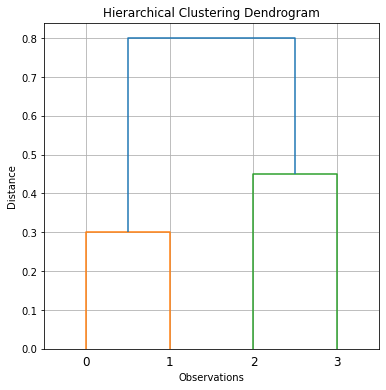

In [54]:
X = np.array([[0, 0.3, 0.4, 0.7],
              [0.3, 0, 0.5, 0.8],
              [0.4, 0.5, 0, 0.45],
              [0.7, 0.8, 0.45, 0]])

dis_X = X[np.triu_indices(X.shape[0],1)]
Z = linkage(dis_X, 'complete')
fig = plt.figure(figsize=(6, 6))
dn = dendrogram(Z)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.grid()
plt.show()

#### (b) Repeat (a), this time using single linkage clustering.

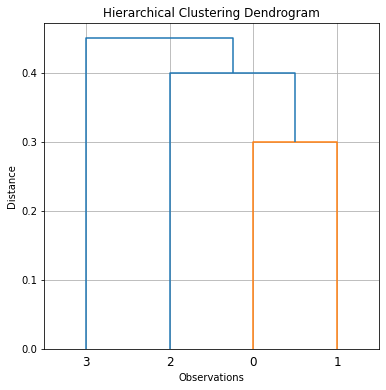

In [55]:
Z = linkage(dis_X, 'single')
fig = plt.figure(figsize=(6, 6))
dn = dendrogram(Z)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.grid()
plt.show()

#### (c) Suppose that we cut the dendrogram obtained in (a) such that two clusters result. Which observations are in each cluster?

<strong>Answer</strong>
One cluster will be (0,1), another cluster will be (2,3)

#### (d) Suppose that we cut the dendrogram obtained in (b) such that two clusters result. Which observations are in each cluster?

<strong>Answer</strong>
One cluster will be (3) , another cluster will be (2,0,1)

#### (e) It is mentioned in the chapter that at each fusion in the dendrogram, the position of the two clusters being fused can be swapped without changing the meaning of the dendrogram. Draw a dendrogram that is equivalent to the dendrogram in (a), for which two or more of the leaves are repositioned, but for which the meaning of the dendrogram is the same.

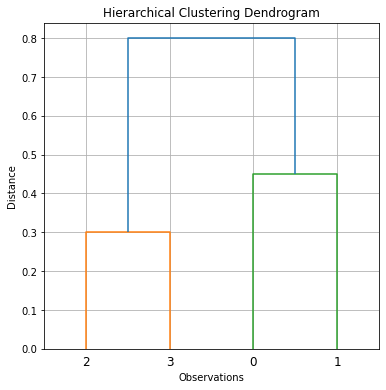

In [56]:
X = np.array([[0, 0.3, 0.4, 0.7],
              [0.3, 0, 0.5, 0.8],
              [0.4, 0.5, 0, 0.45],
              [0.7, 0.8, 0.45, 0]])

dis_X = X[np.triu_indices(X.shape[0],1)]
Z = linkage(dis_X, 'complete')
fig = plt.figure(figsize=(6, 6))
dn = dendrogram(Z,labels=[2,3,0,1])
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.grid()
plt.show()